In [155]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
import torchvision

import torchvision.models as models


""" !wget "https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py" -q -O d2l.py
import d2l

import keras """;


In [156]:
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)

# The dataset are sets of images of drivers, carrying out different actions.
### The 10 classes to predict are:
c0: normal driving \
c1: texting - right \
c2: talking on the phone - right \
c3: texting - left \
c4: talking on the phone - left \
c5: operating the radio \
c6: drinking \
c7: reaching behind \
c8: hair and makeup \
c9: talking to passenger 

In [157]:
df = pd.read_csv("src/driver_imgs_list.csv")

# For pilot study, we approach this with binary classification: 
# Normal driving c0 vs not_c0 (designated as c1) 
#df["classname"].loc[df["classname"] != "c0"] = "c1"

print(f'Unique people total: {len(df["subject"].unique())}\n{df["subject"].unique()}\n')

print(f'Unique classes: {np.unique(df["classname"])}\nCounts for each: {np.unique(df["classname"], return_counts=True)[1]}\n')

people = df["subject"].unique()


Unique people total: 26
['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p024' 'p026' 'p035'
 'p039' 'p041' 'p042' 'p045' 'p047' 'p049' 'p050' 'p051' 'p052' 'p056'
 'p061' 'p064' 'p066' 'p072' 'p075' 'p081']

Unique classes: ['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9']
Counts for each: [2489 2267 2317 2346 2326 2312 2325 2002 1911 2129]



In [158]:
#y = df["classname"]
#X = df.drop(columns=["classname"]).copy()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #doesn't stop people being in both train/test



train_idx = np.random.choice(people, 20, replace=False)
test_idx = [x for x in people if (x in train_idx)==False]

train = df[df.subject.isin(train_idx)].copy()
test= df[df.subject.isin(test_idx)].copy()

y_train = train["classname"]
X_train = train.drop(columns=["classname"]).copy()

y_test = test["classname"]
X_test = test.drop(columns=["classname"]).copy()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train.head(5)

(16876, 2) (16876,) (5548, 2) (5548,)


,subject,img
0,p002,img_44733.jpg
1,p002,img_72999.jpg
2,p002,img_25094.jpg
3,p002,img_69092.jpg
4,p002,img_92629.jpg


In [159]:
y_train = y_train.map(lambda x: int(x[1:]))
y_test = y_test.map(lambda x: int(x[1:]))

In [160]:
##classes are similar although not exactly the same as original
print(f'Unique classes train: {np.unique(y_train)}\nCounts for each     : {np.unique(y_train, return_counts=True)[1]}\n')
print(f'Unique classes test : {np.unique(y_test)}\nCounts for each     : {np.unique(y_test, return_counts=True)[1]}\n')


Unique classes train: [0 1 2 3 4 5 6 7 8 9]
Counts for each     : [1920 1694 1749 1775 1762 1738 1761 1504 1398 1575]

Unique classes test : [0 1 2 3 4 5 6 7 8 9]
Counts for each     : [569 573 568 571 564 574 564 498 513 554]



In [161]:
val_img = set(X_test["img"])

In [162]:
classes = list(y_test.unique())

In [163]:
# import required module
import os
import shutil
# assign directory
directory_train = 'src/imgs/train/'
dest_train = 'src/train_m'

dest_train_c0 = 'src/train_m/c0'
dest_train_c1 = 'src/train_m/c1'
dest_train_c2 = 'src/train_m/c2'
dest_train_c3 = 'src/train_m/c3'
dest_train_c4 = 'src/train_m/c4'
dest_train_c5 = 'src/train_m/c5'
dest_train_c6 = 'src/train_m/c6'
dest_train_c7 = 'src/train_m/c7'
dest_train_c8 = 'src/train_m/c8'
dest_train_c9 = 'src/train_m/c9'

dest_val_c0 = 'src/val_m/c0'
dest_val_c1 = 'src/val_m/c1'
dest_val_c2 = 'src/val_m/c2'
dest_val_c3 = 'src/val_m/c3'
dest_val_c4 = 'src/val_m/c4'
dest_val_c5 = 'src/val_m/c5'
dest_val_c6 = 'src/val_m/c6'
dest_val_c7 = 'src/val_m/c7'
dest_val_c8 = 'src/val_m/c8'
dest_val_c9 = 'src/val_m/c9'

from distutils.dir_util import copy_tree


#copy_tree(directory_train, dest_train)


'''for file in os.listdir(dest_train_c0):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c0,file), dest_val_c0)

for file in os.listdir(dest_train_c1):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c1,file), dest_val_c1)

for file in os.listdir(dest_train_c2):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c2,file), dest_val_c2)

for file in os.listdir(dest_train_c3):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c3,file), dest_val_c3)

for file in os.listdir(dest_train_c4):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c4,file), dest_val_c4)

for file in os.listdir(dest_train_c5):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c5,file), dest_val_c5)

for file in os.listdir(dest_train_c6):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c6,file), dest_val_c6)

for file in os.listdir(dest_train_c7):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c7,file), dest_val_c7)

for file in os.listdir(dest_train_c8):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c8,file), dest_val_c8)

for file in os.listdir(dest_train_c9):
    if file in val_img:
        shutil.move(os.path.join(dest_train_c9,file), dest_val_c9)''';

In [164]:
# load resnet18:
from torchvision.models import ResNet18_Weights
resnet18 = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all the pre-trained layers
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last layer of the model
num_classes = 10
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_no_normalize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
# We make another transformation without normalization just to visualize the images

# Load the train and validation datasets
train_dataset = ImageFolder('src/train_m', transform=transform)
val_dataset = ImageFolder('src/val_m', transform=transform)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)

In [165]:
from torch.utils.data import DataLoader

# Create data loaders for the train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [166]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in tqdm(range(num_epochs)):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)
        training_loss.append(train_loss)
        

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)
        testing_loss.append(val_loss)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))


In [167]:
model = resnet18

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device avaiable: {device}')
model.to(device)

Device avaiable: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [168]:
training_loss = []
testing_loss = []

In [169]:
# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
#train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

In [170]:
# Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

In [171]:
#torch.save(model.state_dict(), 'model_v2.pt')

model = resnet18
model.load_state_dict(torch.load('model_v2.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [172]:
import matplotlib.pyplot as plt
from multiprocessing import Pool

def predict_image(image):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index



def get_random_images(num, data_dir, y):
    data = ImageFolder(data_dir, transform=transform_no_normalize)
    classes = y
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    pool = Pool()
    dataiter = pool.map(iter,loader)
    images = []
    labels = []
    for it in dataiter:
        i, l = it
        images.append(i)
        labels.append(l)
    return images, labels

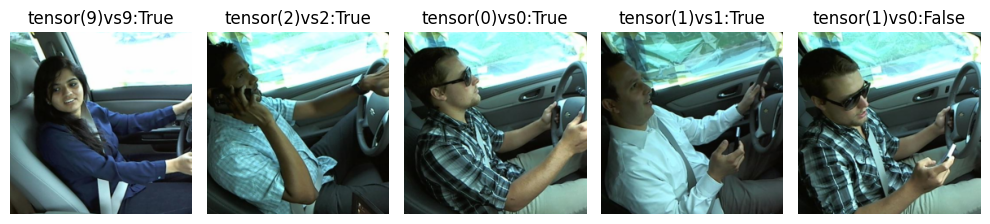

In [173]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5, 'src/val_m', y_test)

fig, ax =plt.subplots(1,5, figsize=(10,10))
ax = ax.flatten()

for ii in range(len(images[0])):
    image = to_pil(images[0][ii,])
    index = predict_image(image)
    r = int(labels[0][ii]) == index
    ax[ii].set_title(str(labels[0][ii]) + 'vs' + str(index) + ":" + str(r))
    ax[ii].axis('off')
    
    ax[ii].imshow(image)

plt.tight_layout()
plt.show()

In [174]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [175]:
np.random.seed(42)
images, labels = get_random_images(500, 'src/val_m', y_test)
res = []
for ii in range(len(images[0])):
    image = to_pil(images[0][ii,])
    index = predict_image(image)
    r = int(labels[0][ii]) == index
    res.append(index)

384


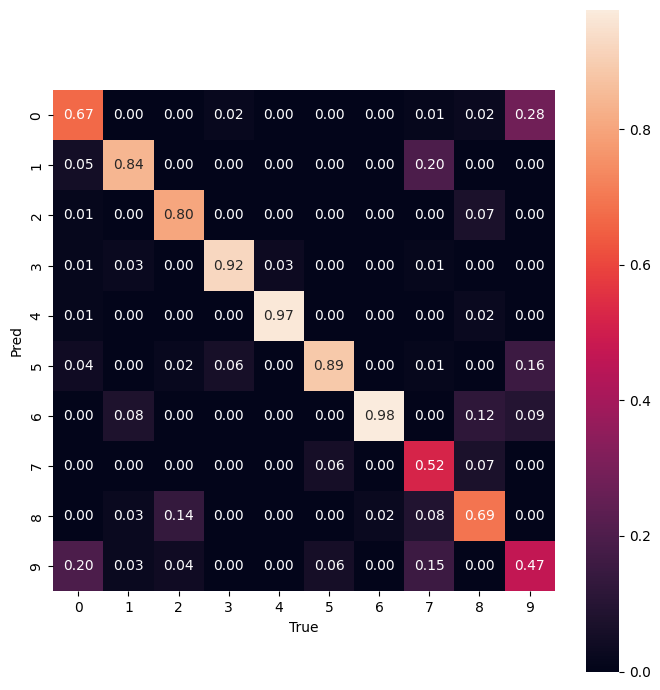

In [176]:
print(sum([1 if i == j else 0 for i,j in zip(res, labels[0])]))

_, counts = np.unique(np.array(res), return_counts=True)

cm = confusion_matrix(y_true=labels[0], y_pred=res)

_, ax = plt.subplots(1,1, figsize=(7,7))

sns.heatmap(cm/counts, annot=True, fmt='.2f', square=True, ax=ax)
plt.xlabel('True')
plt.ylabel('Pred')
plt.tight_layout();

In [177]:
images = images[0]

In [178]:
from torchvision.utils import make_grid
from PIL import Image

def feature_importance(model, images, category):
    ##from exercises
    f1 = model.conv1(images)
    f2 = model.bn1(f1)
    f3 = model.relu(f2)
    f4 = model.maxpool(f3)
    f5 = model.layer1(f4)
    f6 = model.layer2(f5)
    f7 = model.layer3(f6)
    f8 = model.layer4(f7)

    f8.retain_grad()

    f9 = model.avgpool(f8).reshape(-1,512)
    out = model.fc(f9)

    torch.mean(out[:,category]).backward()

    pooled_feature_gradient = torch.mean(f8.grad, dim=[0, 2, 3])

    heatmap = F.relu(torch.mean(f8 * pooled_feature_gradient[:, None, None], dim=1))

    heatmap = heatmap / torch.amax(heatmap, dim=(1, 2))[:, None, None]
    return heatmap, pooled_feature_gradient, f8

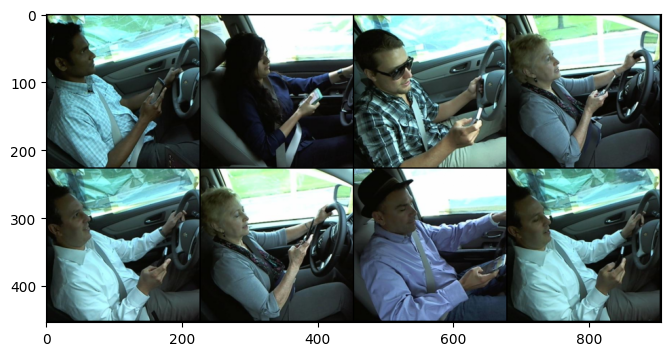

In [179]:
folder = './src/val_m/c1'

images = []
images_orig = []
for file in os.listdir(folder)[0:8]:
    if file.endswith('jpg'):

        img = Image.open(rf'{folder}/' + file)
        images.append(transform(img))
        images_orig.append(transform_no_normalize(img))

images = torch.stack(images).to(device)
# This command is important to move the images also to memory on GPU. Otherwise pytorch will complain.

fig = plt.figure(figsize=(16,4))
img_grid = make_grid(images_orig, nrow=4)
# this is a torchvision utility to put images together into a grid for plotting

plt.imshow(img_grid.detach().numpy().transpose(1,2,0))
# the transpose command above re-arranges the order of dimensions of a tensor.
# make_grid by default generates a tensor of channel x height x width.
# But matplotlib assumes that red, green and blue channels are in the last dimension of a tensor.
plt.show()

In [180]:
logit = model(images)
# By simply passing the image as input, the network

pred_id = logit.argmax(dim=1) # the class with the highest logit will have the highest probability
print('predicted category ID:', pred_id)

pred_class = [classes[class_id]  for class_id in pred_id.detach().cpu().numpy()]
print('network classification:', pred_class)

class_id = torch.mode(pred_id).values
print('ID of the class:', class_id)

predicted category ID: tensor([1, 1, 1, 1, 1, 1, 9, 1], device='cuda:0')
network classification: [1, 1, 1, 1, 1, 1, 9, 1]
ID of the class: tensor(1, device='cuda:0')


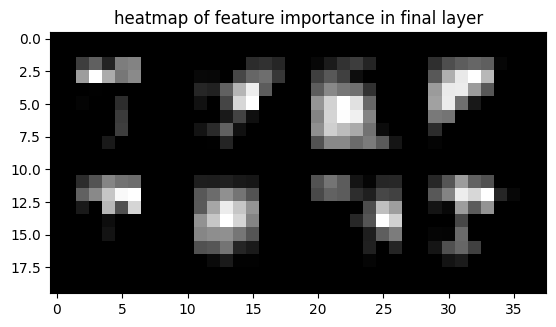

/tmp/ipykernel_315/1521458795.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


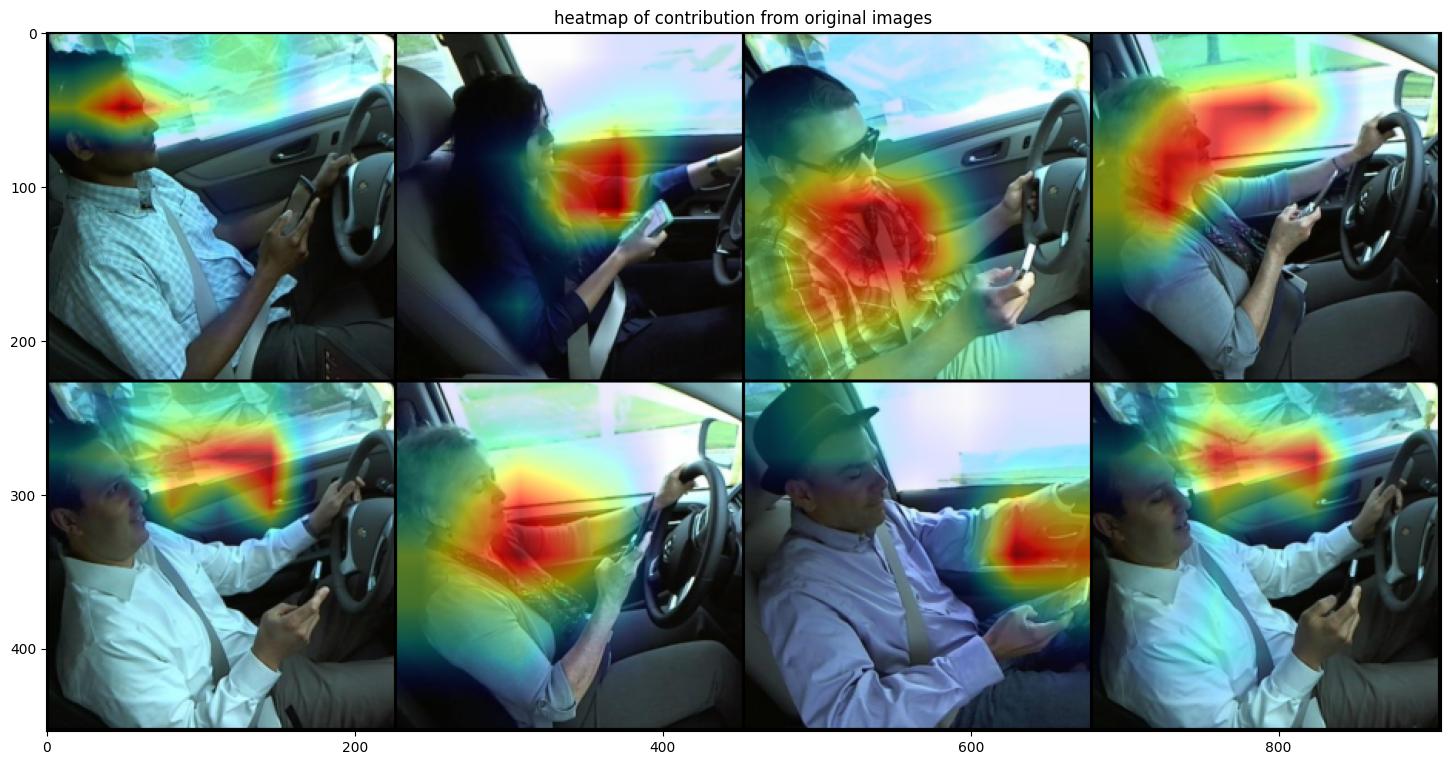

In [181]:
# @title ##### Now we analyze the layer right before the final pooling using the sample images. You can also try other layers
import matplotlib.cm as cm 
heatmap, pooled_feature_gradient, features = feature_importance(model, images, 0)
# Yatta! Now we can visualize both the contribution map in that layer, and blend the contribution map

hms = heatmap.detach().cpu()[:,None,:,:]

plt.imshow(make_grid(hms,nrow=4).numpy().transpose(1,2,0), cmap='jet')
plt.title('heatmap of feature importance in final layer')
plt.show()

cmap = cm.get_cmap('jet')
resized_heatmap = transforms.Resize(224)(heatmap.detach())
resized_heatmap_color = cmap(resized_heatmap.cpu().numpy())[:,:,:,:3].transpose(0, 3, 1, 2)

#plt.imshow(hms[0,0,:,:], cmap='jet', interpolation='nearest')
#plt.show()
#plt.imshow(resized_heatmap[0,:,:].cpu().detach().numpy(), cmap='jet', interpolation='nearest')
#plt.show()

weight = resized_heatmap[:,None,:,:].cpu().numpy() * 0.8
highlighted_images = torch.stack(images_orig) * (1 - weight) + resized_heatmap_color * weight
img_grid = make_grid(highlighted_images, nrow=4)
plt.figure(figsize=(18,12))
plt.imshow(img_grid.numpy().transpose(1,2,0))
plt.title('heatmap of contribution from original images')
plt.show()